<a href="https://colab.research.google.com/github/Aryan625/One-shot-Learning-using-Siamese-Network/blob/main/One_shot_Learning_using_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

###Prepare the Dataset

####Below are few utilities fuctiion for preparing and visualizing the dataset.

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images.reshape(train_images.shape[0],28,28,1)
test_images = test_images.reshape(test_images.shape[0],28,28,1)

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [4]:
tr_pairs.shape

(119980, 2, 28, 28, 1)

Below is the code to visualize sample pair of images

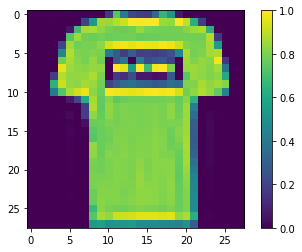

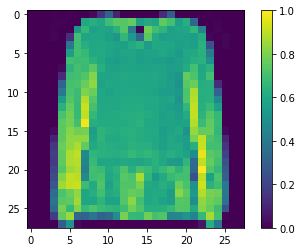

0.0


In [5]:
# array index
# even index no. show pair of images belonging to same class and odd index no. show pair of images belonging to different class
this_pair = 1

# show images at this index
left_image = tr_pairs[this_pair][0].reshape(28, 28)
right_image = tr_pairs[this_pair][1].reshape(28, 28)
show_image(left_image)
show_image(right_image)

# print the label for this pair
# tr_y = 0:different class;  tr_y = 1:same class
print(tr_y[this_pair])

### Build the Model
Below code define the base network of model as well as the euclidean distance between two images for measuring how similar or dissimilar they are.

In [15]:
def initialize_base_network():
    input = tf.keras.layers.Input(shape=(28,28,1,), name="base_input")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(input)
    # x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(input)
    # x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

####Below code is used to build the **Siamese Network**.

In [16]:
base_network = initialize_base_network()

# create the left input and point to the base network
input_a = Input(shape=(28,28,1,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,1,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

###Train the Model


In [17]:
# Below code defines the custom loss for the network

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [18]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9))
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 21s 22ms/step - loss: 0.1282 - val_loss: 0.0942
Epoch 2/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0980 - val_loss: 0.0838
Epoch 3/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0892 - val_loss: 0.0787
Epoch 4/20
938/938 [==============================] - 20s 22ms/step - loss: 0.0835 - val_loss: 0.0742
Epoch 5/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0791 - val_loss: 0.0713
Epoch 6/20
938/938 [==============================] - 20s 22ms/step - loss: 0.0756 - val_loss: 0.0706
Epoch 7/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0726 - val_loss: 0.0676
Epoch 8/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0699 - val_loss: 0.0645
Epoch 9/20
938/938 [==============================] - 21s 22ms/step - loss: 0.0677 - val_loss: 0.0629
Epoch 10/20
938/938 [==============================] - 21s 22ms/step - loss: 0.065

###Model Evaluation

In [19]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
        If the distance is less than 0.5 the pair of images will be consider similar giving output 1.0 or vice-versa'''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [22]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print(f"Loss = {loss:.2f}, Train Accuracy = {train_accuracy*100:.2f} %, Test Accuracy = {test_accuracy*100:.2f} %")

625/625 [==============================] - 2s 3ms/step - loss: 0.0524
Loss = 0.05, Train Accuracy = 94.86 %, Test Accuracy = 93.32 %


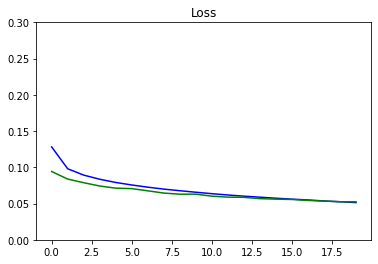

In [21]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.3)

Below code provides Utility to display any two images from test dataset and the prediction that whether they belong to same or different class

In [13]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # prediction of object belonging to different class is shown in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

#### Visualized sample results for 10 pairs of items below.

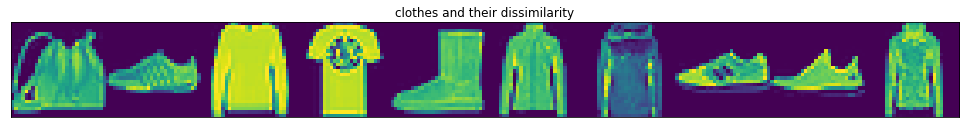

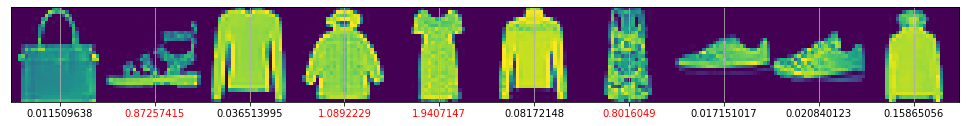

In [14]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)